###### 모듈화 해서 tf.function decorating 으로 Graph Section 최소화
###### Noise 추가하여 Ch6로 진행
###### As Is : Augmentation 도면과 결과물 1:1 매칭 → 도면 변화 X + 결과만 Crop 등 진행

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import random
import time
from IPython.display import clear_output
import os
import glob

2023-05-22 14:58:48.082267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# drawing_list = []
# drawing_cycle_gan = cv.imread('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\drawing_cycle_gan.jpg')
# drawing_target = cv.imread('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\drawing_target.jpg')
# drawing_c_gan_1 = cv.imread('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\drawing_c_gan_1.jpg')
# drawing_c_gan_3 = cv.imread('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\drawing_c_gan_3.jpg')

# drawing_list.append(drawing_cycle_gan)
# drawing_list.append(drawing_target)
# drawing_list.append(drawing_c_gan_1)
# drawing_list.append(drawing_c_gan_3)

In [ ]:
# Drawing은 Segmentation 진행 후 Resize 필요

def drawing_segmentation(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Kernel Size 조절해가면서 시도 필요
    k = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    erosion = cv.erode(gray,k)
    ret, thr = cv.threshold(erosion, 0, 255, cv.THRESH_OTSU)
    cnt, label = cv.connectedComponents(thr)
    bg_img = np.zeros_like(img)
    
    return bg_img, cnt, label, erosion, gray

In [ ]:
colors = []
for n, img in enumerate(drawing_list):
    bg_img, cnt, label, erosion, gray = drawing_segmentation(img)
   
    for i in range(cnt):
        if n == 0:
            color = [int(j) for j in np.random.randint(0,255,3)]
            bg_img[label==i] = color
            colors.append(color)
        else:
            bg_img[label==i] = colors[i]
    
    if max(bg_img.shape)>256:
        scale = 256/max(bg_img.shape)
        bg_img = cv.resize(bg_img, dsize=(256,256))
        img = img / 127.5 - 1
    
    drawing_list[n] = bg_img
    

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 4)
for i in range(len(drawing_list)):
    axs[i].imshow(drawing_list[i])

In [ ]:
dir_list = os.listdir('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\')

In [ ]:
cycle_gan_list = [file for file in dir_list if file.startswith("cycle_gan") and file.endswith('.jpg')]
c_gan_1_list = [file for file in dir_list if file.startswith("c_gan_1") and file.endswith('.jpg')]
c_gan_3_list = [file for file in dir_list if file.startswith("c_gan_3") and file.endswith('.jpg')]
c_gan_2_list = [file for file in dir_list if file.startswith("c_gan_2") and file.endswith('.jpg')]

In [ ]:
def preprocessing_img(path):
    img = cv.imread(path)
    if max(img.shape)>256:
        scale = 256/max(img.shape)
        img = cv.resize(img, dsize=(256,256))
        img = img / 127.5 - 1    
    return img

In [ ]:
def preprocessing_list(lists):
    for i, address in enumerate(lists):
        if address.endswith('.npy'):
            pass
        else:
            path = os.path.join("C:\\Users\\sw991\\project\\230501_GAN\\image_data", address)
            img = preprocessing_img(path)
            print(path)

            lists[i] = img

In [ ]:
preprocessing_list(cycle_gan_list)
preprocessing_list(c_gan_1_list)
preprocessing_list(c_gan_3_list)

In [ ]:
def data_augmentation(drawing, real):
        
    x1 = random.randint(0,20)
    x2 = x1 + 235

    y1 = random.randint(0,20)
    y2 = y1 + 235
    new_drawing = drawing[y1:y2,x1:x2,:]
    new_real = real[y1:y2,x1:x2,:]

    new_drawing = cv.resize(new_drawing, dsize=(drawing.shape[1], drawing.shape[0]))
    new_real = cv.resize(new_real, dsize=(drawing.shape[1], drawing.shape[0]))
        
    (h, w) = drawing.shape[:2]
    (cx, cy) = (w/2, h/2)
    angle = np.random.randint(0,360)
    matrix = cv.getRotationMatrix2D((cx,cy),angle,1.0)
    new_drawing = cv.warpAffine(new_drawing, matrix, (w,h))
    new_real = cv.warpAffine(new_real, matrix, (w,h))
    
    mode = random.randint(-1,2)
    if mode != 2:
        new_drawing = cv.flip(new_drawing, mode)
        new_real = cv.flip(new_real, mode)
    else:
        pass

    return new_drawing, new_real
    

In [ ]:
def list_augmentation(drawings, reals):
    for iteration in range(300):
        idx = np.random.randint(0,len(reals))
        drawing, real = data_augmentation(drawings, reals[idx])

        drawing = np.expand_dims(drawing, axis = 0)
        real = np.expand_dims(real, axis = 0)
        if iteration == 0:
            drawing_numpy = drawing
            real_numpy = real
        else:
            drawing_numpy = np.vstack((drawing_numpy, drawing))
            real_numpy = np.vstack((real_numpy, real))
    return drawing_numpy, real_numpy

In [ ]:
a,b = list_augmentation(drawing_list[0], cycle_gan_list)
c,d = list_augmentation(drawing_list[2], c_gan_1_list)
e,f = list_augmentation(drawing_list[3], c_gan_3_list)


In [ ]:
print(a.shape, b.shape, c.shape, d.shape, e.shape, f.shape)

In [ ]:
np.save('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\cycle_gan_drawing',a)
np.save('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\cycle_gan_img',b)

np.save('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\c_gan_1_drawing',c)
np.save('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\c_gan_1_img',d)

np.save('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\c_gan_3_drawing',e)
np.save('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\c_gan_3_img',f)

np.save('C:\\Users\\sw991\\project\\230501_GAN\\image_data\\drawing_list',drawing_list)

In [ ]:
ls

In [2]:
# cycle_gan_drawing = np.load('./image_data/cycle_gan_drawing.npy')
cycle_gan_img = np.load('./image_data/cycle_gan_img.npy')

# c_gan_1_drawing = np.load('./image_data/c_gan_1_drawing.npy')
c_gan_1_img = np.load('./image_data/c_gan_1_img.npy')

# c_gan_3_drawing = np.load('./image_data/c_gan_3_drawing.npy')
c_gan_3_img = np.load('./image_data/c_gan_3_img.npy')

In [3]:
all_digit = np.vstack((cycle_gan_img, c_gan_1_img))
all_digit = np.vstack((all_digit, c_gan_3_img))
print(all_digit.shape)

(900, 256, 256, 3)


In [4]:
label_0 = np.expand_dims(np.zeros((300,)), axis = -1)
label_1 = np.expand_dims(np.ones((300,)), axis = -1)
label_3 = np.expand_dims(np.ones((300,)) * 3, axis = -1)

all_label = np.vstack((label_0, label_1))
all_label = np.vstack((all_label, label_3))
print(all_label.shape)

(900, 1)


In [5]:
all_data = [all_digit, all_label]

In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose, UpSampling2D, Input, Concatenate, Activation, Embedding
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Flatten, Multiply
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/home/nad/miniconda3/envs/piptest1/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
image_size = 256
z_dim = 128
image_shape = (image_size, image_size, 3)

In [8]:
# generator의 Input이 z_dim + label's channel 임을 확인
def Generator(z_dim):
    input_tensor = Input(shape=(z_dim+1,))
    x = Dense(256*8*8)(input_tensor)
    x = Reshape((8,8,256))(x)
    
    # 16 * 16 * 128
    x = Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)

    # 32 * 32 * 64
    x = Conv2DTranspose(64, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)

    # 64 * 64 * 32
    x = Conv2DTranspose(32, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)

    # 128 * 128 * 16
    x = Conv2DTranspose(16, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    
    # 256 * 256 * 8
    x = Conv2DTranspose(8, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.01)(x)
    
    # 256 * 256 * 3
    x = Conv2DTranspose(3, kernel_size = 3, strides = 1, 
                        padding = 'same')(x)
    output = Activation('tanh')(x)
    
    
    model = Model(input_tensor, output)
    
    return model

In [9]:
# Discriminator의 Input이 (Img_size, Img_size, RGB + label's channel) 임을 확인
def Discriminator():
    input_tensor = Input(shape=(256,256,4))
    
    # 128 * 128 * 8
    x = Conv2D(8, kernel_size = 3, strides = 2, padding = 'same')(input_tensor)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # 64 * 64 * 16
    x = Conv2D(16, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # 32 * 32 * 32
    x = Conv2D(16, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # 16 * 16 * 64
    x = Conv2D(16, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # 8 * 8 * 128
    x = Conv2D(16, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    output = layers.Dense(1)(x)
    
    model = Model(input_tensor, output)
    return model

In [10]:
generator = Generator(z_dim)
discriminator = Discriminator()

In [11]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, z_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.z_dim = z_dim
        self.gen_loss_tracker = keras.metrics.Mean()
        self.disc_loss_tracker = keras.metrics.Mean()
        
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    # Data 넣어줬을 때 Shape[0]이 곧 Batch_size로 써도 가능
    @tf.function
    def train_step(self, data, batch_size ):
        raw_real_imgs = data[0]
        raw_labels = data[1]
        # data 항목에 One-hot encoding 진행하여 Input
        # 소수점 등 집어넣기 위해 일단 OH encoding 미실시
        
        # idx = np.random.randint(0,raw_real_imgs.shape[0],batch_size)
        
        idx = list(np.random.randint(0,raw_real_imgs.shape[0],batch_size))
        
        # real_imgs = raw_real_imgs[idx]
        real_imgs = tf.gather(raw_real_imgs, indices = idx)
        real_imgs = tf.cast(real_imgs, tf.float32)
        
        # labels = raw_labels[idx]
        labels = tf.gather(raw_labels, indices = idx)
        labels = tf.cast(labels, tf.float32)
                
        # label > 256*256*1 size Layer로 만들어 concat 진행
        img_labels = tf.repeat(labels, repeats = [image_size * image_size])
        img_labels = tf.reshape(img_labels, shape=(-1, image_size,
                                                  image_size, 1))
        img_labels = tf.cast(img_labels, tf.float32)
        
        # discriminator 훈련 진행
        z_dim_vector = tf.random.normal(shape = (batch_size, self.z_dim))
        random_vector_labels = tf.concat([z_dim_vector, labels], axis = 1)
        #random_vector_labels의 shape이 (Batch_size, channel)이고, Generator Input과 같아야함
    
        generated_imgs = self.generator(random_vector_labels)


        fake_imgs_and_labels = tf.concat([generated_imgs, img_labels], axis = -1)
        real_imgs_and_labels = tf.concat([real_imgs, img_labels], axis = -1)
        
        combined_imgs = tf.concat([fake_imgs_and_labels, real_imgs_and_labels], 
                                 axis = 0)
        
        combined_labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))],
                          axis = 0)
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_imgs)
            d_loss = self.loss_fn(combined_labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, 
                                             self.discriminator.trainable_weights))
        
        
        # generator 훈련 할 때 Discriminator를 훈련하지 않는 것인지 확인 필요
        z_dim_vector = tf.random.normal(shape = (batch_size, self.z_dim))
        random_vector_labels = tf.concat([z_dim_vector, labels], axis = 1)
        misleading_labels = tf.zeros((batch_size,1))
        
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, img_labels], axis = -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
        
        
        

In [12]:
cond_gan = ConditionalGAN(discriminator=discriminator, 
                          generator=generator, 
                          z_dim=z_dim)
cond_gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                 g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                 loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

In [13]:
def generate_images(model, epoch, z_dim):
    test_labels = np.array([[0],[1],[2],[3]])
    z_dim_vector = tf.random.normal(shape = (4, z_dim))
    random_vector_labels = tf.concat([z_dim_vector, test_labels], axis = 1)

    prediction = model(random_vector_labels)
    plt.figure(figsize=(24, 12))
    title = ['0', '1', '2', '3']

    for i in range(test_labels.shape[0]):
        
        plt.subplot(1, test_labels.shape[0], i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(prediction[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig('./image/Conditional_GAN_Image 1800+%d.png' %(epoch+1))
    # Plt.show() 전에 저장 필요
    plt.show()


In [18]:
epochs = 1000000
batch_size = 32

In [ ]:
cond_gan.load_weights('./checkpoints/my_checkpoint')

Time taken for epoch 1 is 28.98928737640381 sec

Time taken for epoch 2 is 26.572782516479492 sec

Time taken for epoch 3 is 26.631739854812622 sec

Time taken for epoch 4 is 26.627573490142822 sec

Time taken for epoch 5 is 26.60893726348877 sec

Time taken for epoch 6 is 26.58758306503296 sec

Time taken for epoch 7 is 26.569708108901978 sec

Time taken for epoch 8 is 26.60407567024231 sec

Time taken for epoch 9 is 26.660960912704468 sec

Time taken for epoch 10 is 26.708879232406616 sec

Time taken for epoch 11 is 26.706591606140137 sec

Time taken for epoch 12 is 26.727518320083618 sec

Time taken for epoch 13 is 26.696998357772827 sec

Time taken for epoch 14 is 26.688432693481445 sec

Time taken for epoch 15 is 26.661130666732788 sec

Time taken for epoch 16 is 26.670687675476074 sec

Time taken for epoch 17 is 26.70029330253601 sec

Time taken for epoch 18 is 26.684024810791016 sec

Time taken for epoch 19 is 26.7883141040802 sec

Time taken for epoch 20 is 26.607224464416504 s

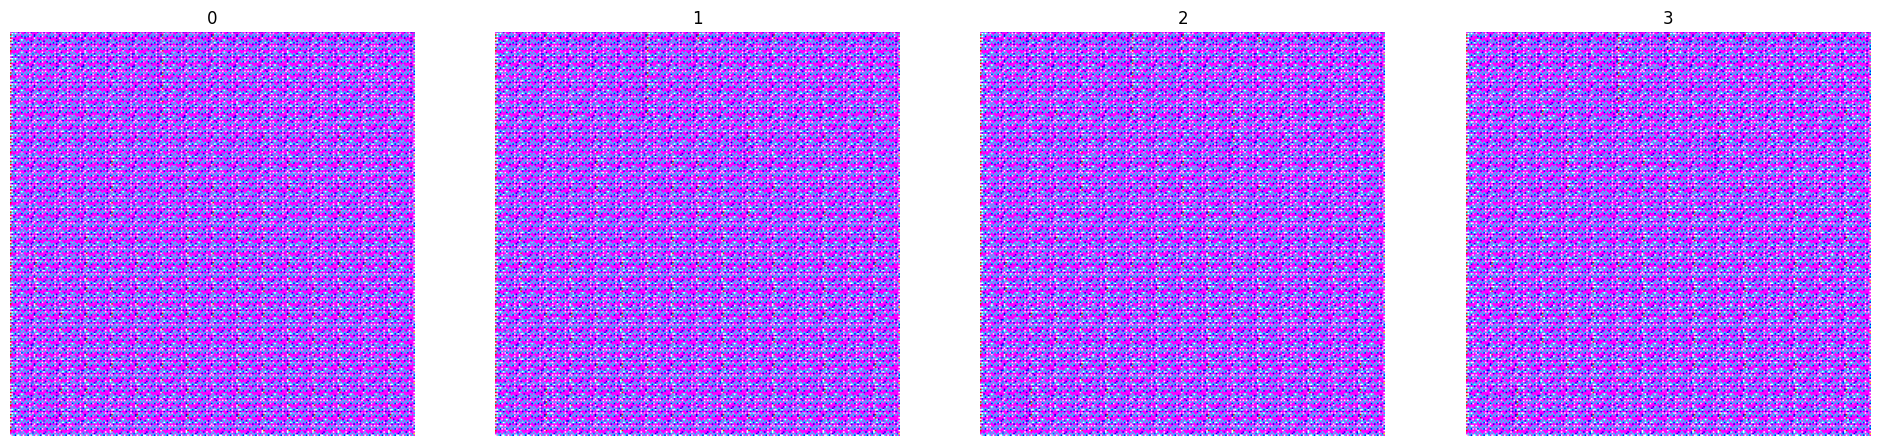

Time taken for epoch 50 is 28.622035026550293 sec

Time taken for epoch 51 is 27.104753255844116 sec

Time taken for epoch 52 is 26.79076647758484 sec

Time taken for epoch 53 is 26.7602641582489 sec

Time taken for epoch 54 is 26.72403573989868 sec

Time taken for epoch 55 is 26.7663357257843 sec

Time taken for epoch 56 is 26.708377361297607 sec

Time taken for epoch 57 is 26.818641901016235 sec

Time taken for epoch 58 is 26.657646656036377 sec

Time taken for epoch 59 is 26.63442897796631 sec

Time taken for epoch 60 is 26.652486562728882 sec

Time taken for epoch 61 is 26.760444164276123 sec

Time taken for epoch 62 is 26.782645225524902 sec

Time taken for epoch 63 is 26.688088178634644 sec

Time taken for epoch 64 is 26.67277717590332 sec

Time taken for epoch 65 is 26.723702669143677 sec

Time taken for epoch 66 is 26.733726263046265 sec

Time taken for epoch 67 is 27.04679560661316 sec

Time taken for epoch 68 is 27.88945174217224 sec

Time taken for epoch 69 is 26.79848885536

In [ ]:
for epoch in range(epochs):
    iterations = int(all_data[0].shape[0] / batch_size)
    start = time.time()

    for iteration in range(iterations):
        cond_gan.train_step(all_data, batch_size)
        
    if (epoch + 1) % 50 == 0:
        generate_images(generator, epoch, z_dim)
        cond_gan.save_weights('./checkpoints/my_checkpoint')
        
    if (epoch + 1) % 250 == 0:
        clear_output(wait=True)
        
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [19]:
pip list

/bin/bash: /home/nad/miniconda3/envs/piptest1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Package                      Version
---------------------------- ---------
absl-py                      1.4.0
anyio                        3.6.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.0
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.1.0
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
executing                    1.2.0
fastjsonschema         

In [7]:
!pip install tensorflow==2.12

/bin/bash: /home/nad/miniconda3/envs/piptest1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 6.9 MB/s eta 0:00:000:00:01
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached tensorboard_data_server-0.7.0-py3-none-manylinux2014_x86_64.whl (6.6 MB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempt

    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1


In [8]:
from tensorflow.python.client import device_lib

ModuleNotFoundError: No module named 'tensorflow.python.client'

In [4]:
device_lib.list_local_devices()

NameError: name 'device_lib' is not defined